# Convolutional Neural Networks with Keras for image classification

this notebook uses some material from https://gitlab.com/wdeback/dl-keras-tutorial by Walter de Back, which in turn is partially based on other tutorials (see there for references).

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

If a GPU is available, execute the following cell:

In [2]:
import tensorflow as tf

Now load the keras modules:

In [3]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras.utils import to_categorical

## Load and prepare the image data
----
We use another famous dataset, the MNIST handwritten digit database: https://en.wikipedia.org/wiki/MNIST_database

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


## Look at the data

Plot the first 25 images together with their ground truth labels:

5


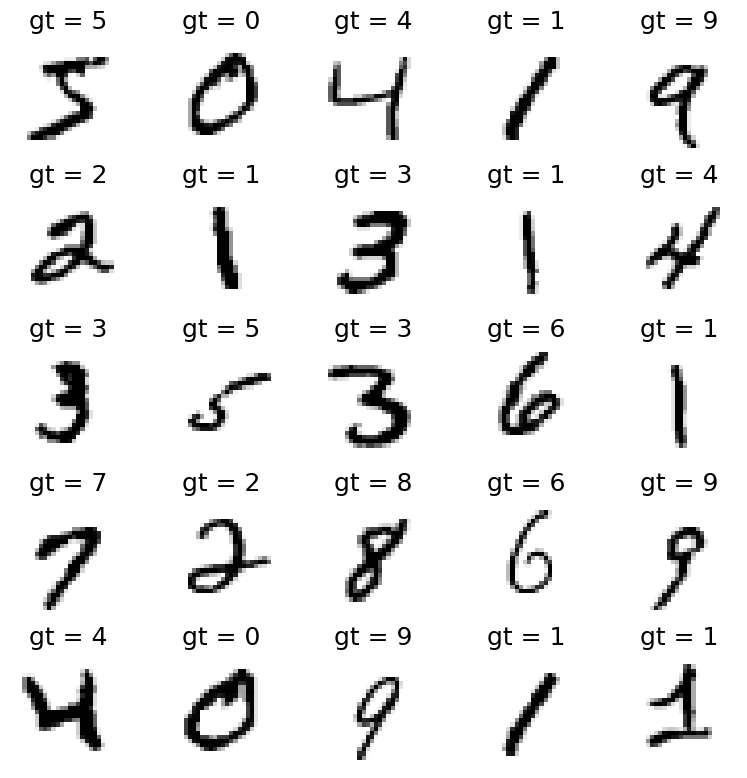

In [5]:
def plot_images(images, labels, gt=None):
    # reduce empty dimensions, if any
    images = np.squeeze(images)
    labels = np.squeeze(labels)
    numrows=int(np.ceil(np.sqrt(images.shape[0])))
    print(numrows)
    fig, axes = plt.subplots(nrows=numrows, ncols=numrows, figsize=(8,8), sharex=True, sharey=True)
    fig.tight_layout()
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=plt.get_cmap('gray_r'))
        ax.set_title('gt = {}'.format(labels[i]), fontsize=18)
        ax.axis('off')
        
        # highlight wrong predictions is gt (ground truth) is provided
        if gt is not None:
            if gt[i] != labels[i]:
                ax.imshow(images[i], cmap=plt.get_cmap('viridis'))
                ax.set_title('{}≠{}'.format(labels[i], gt[i]), fontsize=18, fontdict={'color':'red'})

plot_images(x_train[:25], y_train[:25])

## Prepare data as input tensors
----
In order to be used as input for a convolutional neural network, we have to expand the dimensions:

In [6]:
X_train = np.expand_dims(x_train, 3)
X_test = np.expand_dims(x_test, 3)

Look at the training data:

In [7]:
X_train.shape

(60000, 28, 28, 1)

Same for the test data:

In [8]:
X_test.shape

(10000, 28, 28, 1)

## Converting to float and scaling
----
Next, we convert the data to 32-bit floating point and normalize them:

In [9]:
X_train = X_train.astype('float32')
X_train = X_train.astype('float32')
X_train /= 255.
X_train /= 255.

## One-hot encoding
----
The class vectors need to be converted to one-hot encoding again:

In [10]:
y_train[:5,]

array([5, 0, 4, 1, 9], dtype=uint8)

In [11]:
num_classes=10

Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

Y_train[:5,]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## Define network architecture
----
Now, we again build a network using the sequential API in Keras. Instead of dense layers, we now use 2D convolution layers, dropout and max pooling:

In [13]:
model = Sequential()

# conv layer with 32 3x3 filters and retified linear activation units
# Note: first layer requires the specification of an input shape
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
# conv layer with 64 3x3 filters and retified linear activation units
model.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu'))
# max pooling with size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# dropout layer
model.add(Dropout(0.25))

## Multilayer perceptron (MLP) part

# first, we need to flatten the output of the conv to obtain a vector
model.add(Flatten())
# add a dense NN layer (= fully connected layer of neurons) with ReLU activation
model.add(Dense(128, activation='relu'))
# dropout layer
model.add(Dropout(0.5))
# final layer is equal to the number of classes and uses SoftMax activation 
model.add(Dense(num_classes, activation='softmax'))

2023-12-06 15:38:55.755037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Compile and look at network

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               295040    
                                                        

# Set parameters

In [15]:
batch_size = 128
epochs = 3

# Run training

In [16]:
history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_test, Y_test))

Epoch 1/3
469/469 [==============================] - 15s 32ms/step - loss: 1.2141 - accuracy: 0.5870 - val_loss: 14377.5020 - val_accuracy: 0.8044
Epoch 2/3
469/469 [==============================] - 15s 31ms/step - loss: 0.5631 - accuracy: 0.8214 - val_loss: 9904.3281 - val_accuracy: 0.8633
Epoch 3/3
469/469 [==============================] - 15s 31ms/step - loss: 0.4952 - accuracy: 0.8443 - val_loss: 7954.9951 - val_accuracy: 0.8940


## Evaluate performance of trained network
----
We use the evaluate function to look at loss and accuracy:

In [17]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 7954.9922 - accuracy: 0.8940
Test loss: 7954.9921875
Test accuracy: 0.8939999938011169


## Apply to new unseen data
----
Finally, we want to use the trained model to predict images:

In [18]:
num = 36

y_pred = model.predict(X_test[:num], verbose=1, batch_size=12)

3/3 [==============================] - 0s 2ms/step


In order to get the actual class, we need to find the digit with the highest probability:

In [19]:
Y_pred = np.argmax(y_pred, axis=1)

Now we can use our previously defined plotting function to check the results:

6


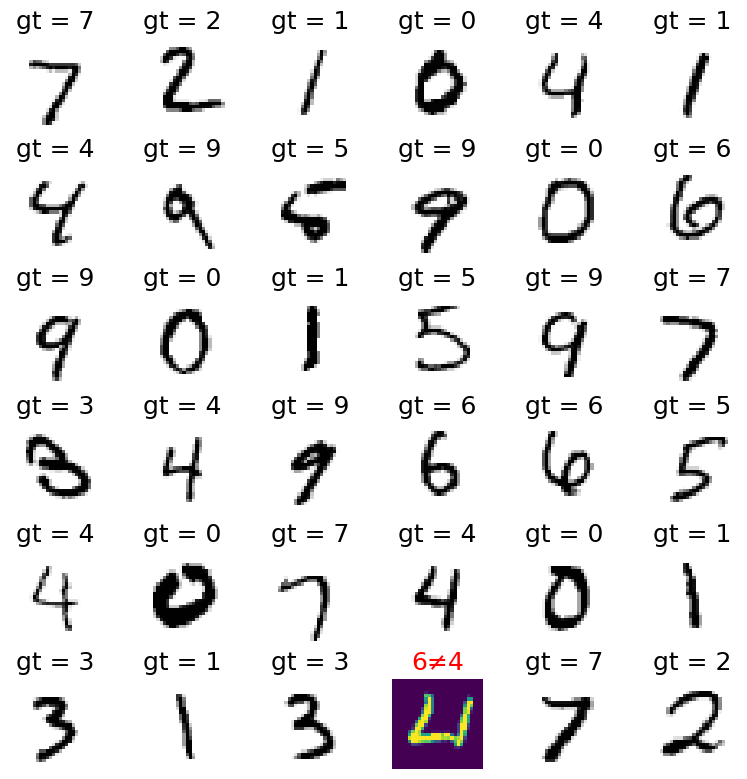

In [20]:
plot_images(X_test[:num], Y_pred, gt=y_test[:num]) 

### TASK: Modify the network architecture and training parameters, and look at the result.